In [1]:
import numpy as np
import scipy as scp
import scipy.io
import skimage.feature
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pdb

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (16.0, 8.0)

Populating the interactive namespace from numpy and matplotlib


C:\Anaconda3\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
tmp = scipy.io.loadmat('lib/data/ball_data.mat')
frames = tmp['frames']  # frames of our video
ball = tmp['ball']  # our little template
 
data = []
for i in range( 0, frames.shape[1] ):
    tmp = np.reshape( frames[:,i], (360,243) ).T  # slurp out a frame
    ncc = skimage.feature.match_template( tmp, ball )  # create a normalized cross correlation image
    maxloc = np.unravel_index( tmp.argmax(), tmp.shape )  # find the point of highest correlation
    data.append( maxloc )  # record the results
 
vis_cor_data = np.asarray( data )

tmp = scipy.io.loadmat('lib/data/kfdata.mat')
observed_data = tmp['data']
true_data = tmp['true_data'] 


In [3]:
tmp

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Wed Feb 17 09:16:05 2016',
 '__version__': '1.0',
 'data': array([[  3.04764674e-01,   1.96642232e+01],
        [  1.52048278e+00,   7.26430661e+00],
        [  5.10213477e+01,   1.64244510e+01],
        [  4.98933123e+01,   5.83947171e+01],
        [  6.96016755e+01,   6.14307259e+01],
        [  9.06497069e+01,   1.12906211e+02],
        [  1.52030673e+02,   1.22398107e+02],
        [  1.84942422e+02,   1.64287182e+02],
        [  2.72203079e+02,   1.86080995e+02],
        [  3.26222798e+02,   2.13626752e+02],
        [  4.05308728e+02,   2.40367017e+02],
        [  4.63167521e+02,   2.44406582e+02],
        [  5.06414910e+02,   2.68374374e+02],
        [  5.59289433e+02,   2.56632142e+02],
        [  5.87199734e+02,   2.40445365e+02],
        [  5.86394908e+02,   2.18893130e+02],
        [  5.97244133e+02,   2.19223005e+02],
        [  5.76612704e+02,   2.00319409e+02],
        [  5.52618428e+02,  

# Kalman Filter Class

In [28]:
class Kalman_Filter:     
    def __init__(self, dataset_num):
        
        
        # Model Data Initial Conditions
        if dataset_num == 2:
            #  tuned to dataset 2
            # our dynamics are described by random accelerations
            self.A = np.asarray([
                [ 1, 0, 0.1, 0, 0.5, 0 ],
                [ 0, 1, 0, 1, 0, 0.5 ],
                [ 0, 0, 1, 0, 0.7, 0 ],
                [ 0, 0, 0, 1, 0, 0.9 ],
                [ 0, 0, 0, 0, 1, 0 ],
                [ 0, 0, 0, 0, 0, 1 ] ])

            # our observations are only the position components
            self.C = np.asarray([
                [1, 0, 0, 0, 0, 0],
                [0, 1, 0, 0, 0, 0]])

            # our dynamics noise tries to force random accelerations to account
            # for most of the dynamics uncertainty
            self.Q = 1e-2 * np.eye( 6 )
            self.Q[0,0] = 10
            self.Q[1,1] = 1
            self.Q[2,2] = 0.001 
            self.Q[3,3] = 0.0001 
            self.Q[4,4] = 0.0001  
            self.Q[5,5] = 0.00001

            # our observation noise
            self.R = 1.0 * np.eye( 2 )
            self.R[0][0] *= 10000
            self.R[0][1] *= 20
            self.mu_t = np.zeros(( 6, 1 ))
            self.mu_t[0] = 150
            self.mu_t[1] = 100
            self.sigma_t = np.eye( 6 )     
            
            
        else:
            #  random accelerations is the default
            # our dynamics are described by random accelerations
            self.A = np.asarray([
                [ 1, 0, 1, 0, 0.5, 0 ],
                [ 0, 1, 0, 1, 0, 0.5 ],
                [ 0, 0, 1, 0, 1, 0 ],
                [ 0, 0, 0, 1, 0, 1 ],
                [ 0, 0, 0, 0, 1, 0 ],
                [ 0, 0, 0, 0, 0, 1 ] ])

            # our observations are only the position components
            self.C = np.asarray([
                [1, 0, 0, 0, 0, 0],
                [0, 1, 0, 0, 0, 0]])

            # our dynamics noise tries to force random accelerations to account
            # for most of the dynamics uncertainty
            self.Q = 1e-2 * np.eye( 6 )
            self.Q[4,4] = 0.5  # variance of accelerations is higher
            self.Q[5,5] = 0.5

            # our observation noise
            self.R = 20 * np.eye( 2 )
            self.mu_t = np.zeros(( 6, 1 ))
            self.sigma_t = np.eye( 6 )

        # initial state

        self.kalman_gain = np.zeros((6,2))
        self.y_hat_t = np.zeros((2,1))

    
    """  this takes a new observation, updates latent states/observations, and
    returns the predicted mean and covariance  """
    def filter_new_observation(self, obs):
        self.predict_covariance() 
        self.update_kalman_gain()  #  2 & 3
        self.predict_observation()
        self.calculate_new_mean(obs)  #  I'll need to save the new y_hat_t
        self.calculate_new_covariance()
        return (self.mu_t, self.sigma_t)
    
    def predict_covariance(self):
        self.sigma_t = (self.A.dot(self.sigma_t).dot(np.atleast_2d(self.A).T)) + self.Q
        
    def update_kalman_gain(self):
        S_t = (self.C.dot(self.sigma_t).dot(np.atleast_2d(self.C).T)) + self.R
        self.kalman_gain = self.sigma_t.dot(np.atleast_2d(self.C).T).dot(np.linalg.pinv(S_t))
        
    def predict_observation(self):
        self.y_hat_t = self.C.dot(self.A).dot(self.mu_t)
        
    def calculate_new_mean(self, y):
        part_1 = (self.A.dot(self.mu_t))
        part_1_5 = np.atleast_2d(y).T - self.y_hat_t
        part_2 = (self.kalman_gain.dot(part_1_5))
        self.mu_t = part_1 + part_2
        self.y_hat_t = y
        
    def calculate_new_covariance(self):
        self.sigma_t = self.sigma_t - (self.kalman_gain.dot(self.C).dot(self.sigma_t))
        
        

        
    def test_filter(self, observed_data, frames, ball=""):
        mus = []
        sigmas = []
#         pdb.set_trace()
        for observation_at_next_step in observed_data:
            (mu, sigma) = self.filter_new_observation(observation_at_next_step)
            mus.append(mu)
            sigmas.append(sigma)
            
            
        
#         self.plot_frame(mus, sigmas, 54)
#         self.plot_frame(mus, sigmas, 56)
#         self.plot_frame(mus, sigmas, 78)
#         self.plot_frame(mus, sigmas, 106)
        self.plot_frame(mus, sigmas, 107)

#         if ball == "":
#             self.print_results_plot(mus, sigmas, observed_data, frames) #  frames = true data in this case
#         else:
#             self.print_ball_tracking_results(mus, sigmas, observed_data, frames, ball)
        
    def print_ball_tracking_results(self, mus, sigmas, observed_data, frames, ball):
        plt.plot(np.asarray(mus)[:,0],np.asarray(mus)[:,1])
#         plt.plot(true_data[:,[0]], true_data[:,[1]])
        plt.scatter(observed_data[10:100,[0]], observed_data[10:100,[1]])
#         for i, sigma in enumerate(sigmas):
#             tmp_cov_points = self.cov_to_pts(sigma[:2,:])
#             plt.plot(tmp_cov_points[0] + np.asarray(mus)[i,0], tmp_cov_points[1] + np.asarray(mus)[i,1])
        plt.legend(["Mu", "Obseration"])

        
        
    def print_results_plot(self, mus, sigmas, observed_data, true_data):
        plt.plot(np.asarray(mus)[:,0],np.asarray(mus)[:,1])
        plt.plot(true_data[:,[0]], true_data[:,[1]])
        plt.scatter(observed_data[:,[0]], observed_data[:,[1]])
        for i, sigma in enumerate(sigmas):
            tmp_cov_points = self.cov_to_pts(sigma[:2,:])
            plt.plot(tmp_cov_points[0] + np.asarray(mus)[i,0], tmp_cov_points[1] + np.asarray(mus)[i,1])
        plt.legend(["Mu", "True", "Obseration"])
            
    def cov_to_pts(self, cov):
        circ = np.linspace( 0, 2*np.pi, 100 )
        sf = np.asarray( [ np.cos( circ ), np.sin( circ ) ] )
        [u,s,v] = np.linalg.svd( cov )
        pmat = u*2.447*np.sqrt(s) # 95% confidence
        return np.dot(  pmat, sf )      

    def plot_frame(self, mus, sigmas, num):
#         for t in range(0, data.shape[0]):

        tmp = np.reshape( frames[:,num], (360,243) ).T

        plt.figure(1)
        plt.clf()
        plt.imshow( tmp, interpolation='nearest', cmap=matplotlib.cm.gray )
        plt.scatter( vis_cor_data[num][1], vis_cor_data[num][0] )
        plt.scatter( mus[num][1], mus[num][0] )

        foo = self.cov_to_pts( sigmas[num][0:2,0:2] )

        plt.plot( foo[0,:] + mus[num][1], foo[1,:] + mus[num][0] )
        plt.xlim([1, 360])
        plt.ylim([243,1])

        plt.pause(0.01)
        


# First dataset

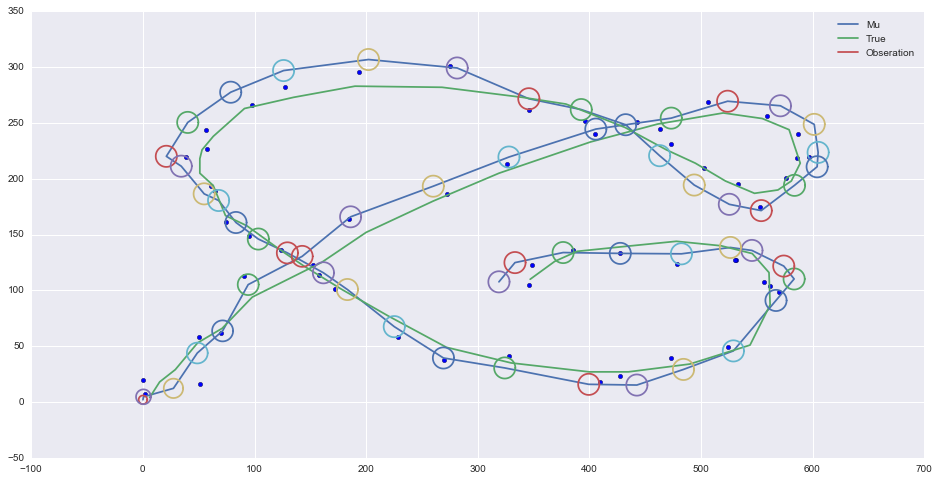

In [6]:
kalman_filter = Kalman_Filter(1)

kalman_filter.test_filter(observed_data, true_data)

# Second Dataset

54

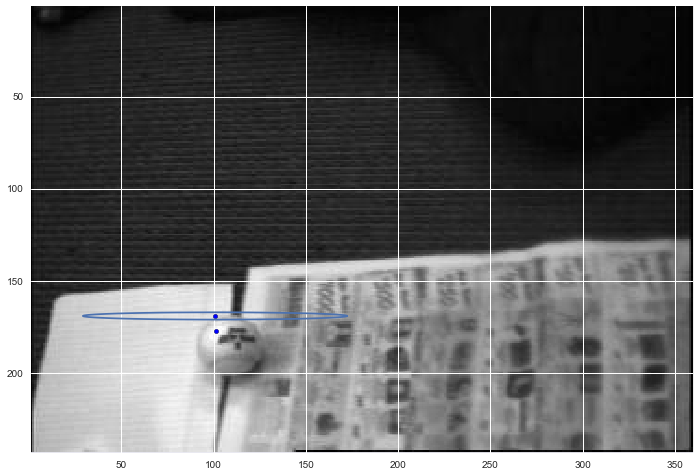

In [21]:
kalman_filter_2 = Kalman_Filter(2)
kalman_filter_2.test_filter(vis_cor_data, frames, ball)

56

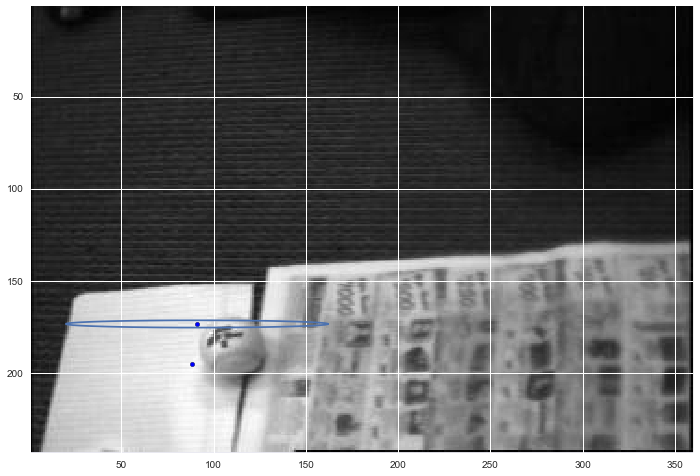

In [23]:
kalman_filter_2 = Kalman_Filter(2)
kalman_filter_2.test_filter(vis_cor_data, frames, ball)

78

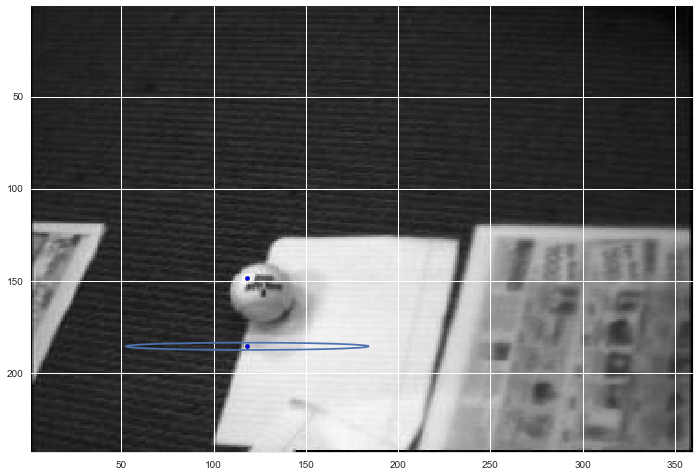

In [25]:
kalman_filter_2 = Kalman_Filter(2)
kalman_filter_2.test_filter(vis_cor_data, frames, ball)

106

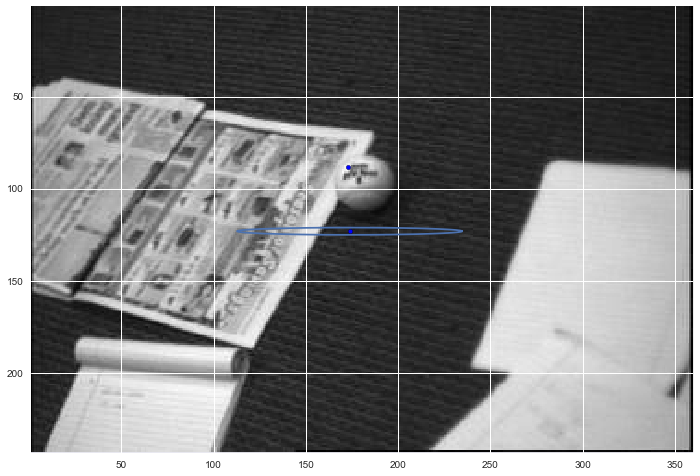

In [27]:
kalman_filter_2 = Kalman_Filter(2)
kalman_filter_2.test_filter(vis_cor_data, frames, ball)

107

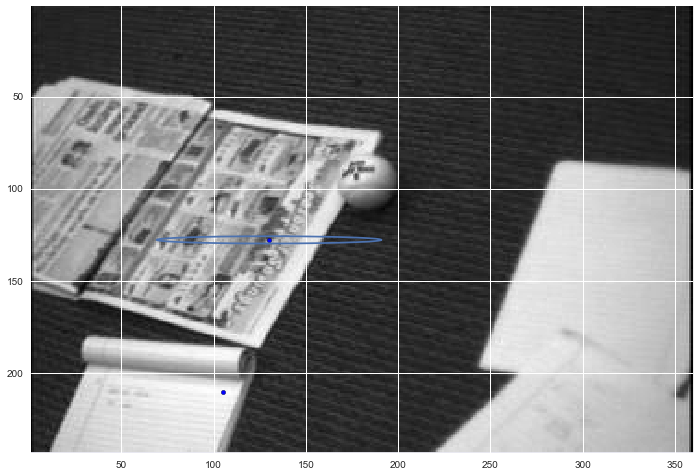

In [29]:
kalman_filter_2 = Kalman_Filter(2)
kalman_filter_2.test_filter(vis_cor_data, frames, ball)

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:116: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


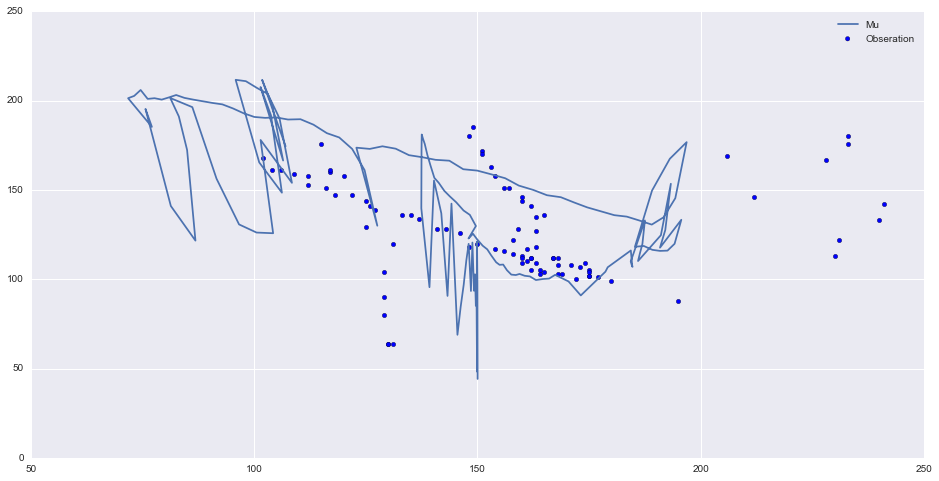

In [5]:
kalman_filter_2 = Kalman_Filter(2)
kalman_filter_2.test_filter(vis_cor_data, frames, ball)

I chose these parameters because first off the x-axis has a lot more variance then the x-axis. This means that there will be much more noise and less defined relationships amoung position, acceleration, and velocity. Because of this I first added a ton of noise to the x observations in R. Then, when setting Q to determine the random accelerations that account for most of the noise I chose most of the noise to be due to position as random points seemed to be added and made sure that all position, velocity, and acceleration along the x-axis in Q was much larger then the corresponding y-axis values. I also decreased the values from position through acceleration as the dynamics seemed to be mostly because of position and less because of velocity or it's integrals. In the A matrix while describes the relationships between data point types I chose position to have very little correlation with velocity in the x-axis (since there seemed to be  random shaking in the video) while I left the y position to y-velocity as is since the y-axis didn't seem to have as much noise. For x-velocity to x acceleratoin I decreased it due to horitinal shakiness of the camera but left the y-velocity to y-acceleration almost as is since it's not as affected. I left the C matrix as is since it just select the points to use. 